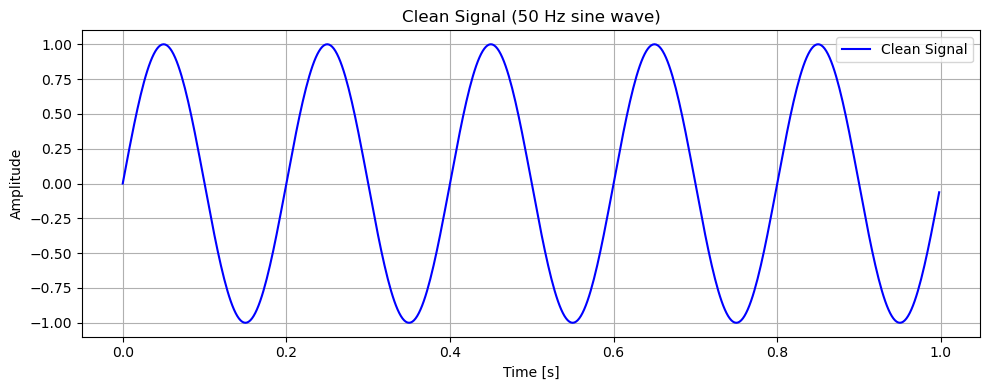

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 500.0                # Sampling frequency (Hz)
T = 1.0                   # Total duration (s)
N = int(fs * T)           # Number of samples
t = np.linspace(0, T, N, endpoint=False)

# Create a clean signal: a 50 Hz sine wave
freq_signal = 5          # Frequency of signal (Hz)
clean_signal = np.sin(2 * np.pi * freq_signal * t)

# Plot the clean signal
plt.figure(figsize=(10, 4))
plt.plot(t, clean_signal, label='Clean Signal', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Clean Signal (50 Hz sine wave)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_50326/27894321.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(fft_freq[:N//2], np.abs(fft_noisy)[:N//2], 'b', markerfmt=" ", basefmt="-b")


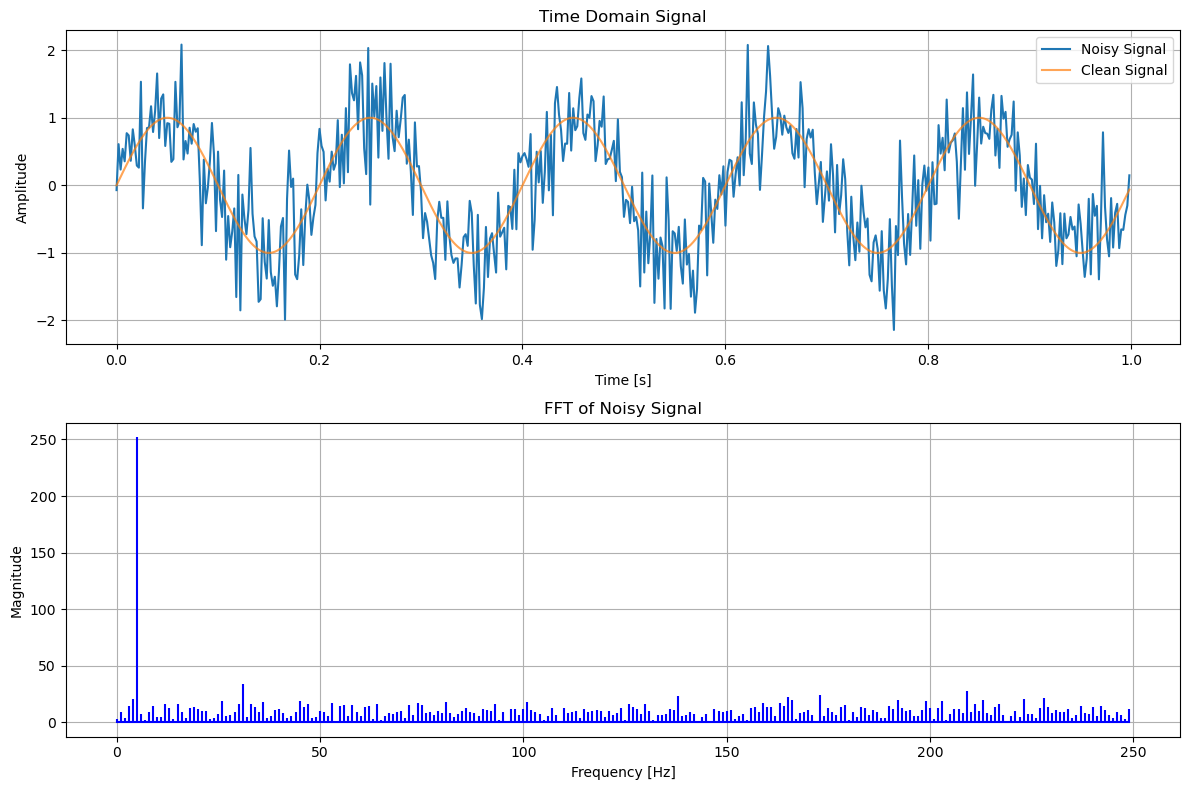

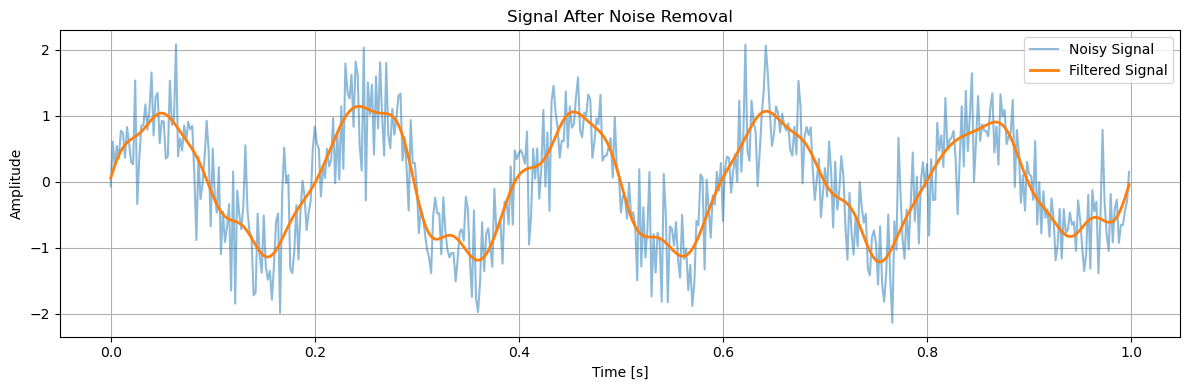

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 500.0                # Sampling frequency (Hz)
T = 1.0                   # Duration (s)
N = int(fs * T)           # Number of samples
t = np.linspace(0, T, N, endpoint=False)

# Create a clean signal (50 Hz sine wave)
freq_signal = 5          # Frequency of signal (Hz)
clean_signal = np.sin(2 * np.pi * freq_signal * t)

# Add noise: Gaussian noise
noise = 0.5 * np.random.randn(N)
noisy_signal = clean_signal + noise

# Compute FFT of the noisy signal
fft_noisy = np.fft.fft(noisy_signal)
fft_freq = np.fft.fftfreq(N, d=1/fs)

# Plot the noisy signal (time domain) and its FFT magnitude
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t, clean_signal, label='Clean Signal', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
# Plot only the positive half of the spectrum
plt.stem(fft_freq[:N//2], np.abs(fft_noisy)[:N//2], 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('FFT of Noisy Signal')
plt.grid(True)
plt.tight_layout()
plt.show()


# Make a copy of the FFT data
fft_filtered = fft_noisy.copy()

# Define a cutoff frequency (e.g., 100 Hz) and zero out frequencies beyond that
cutoff = 25  # Hz
fft_filtered[np.abs(fft_freq) > cutoff] = 0

# Inverse FFT to reconstruct the filtered signal
filtered_signal = np.fft.ifft(fft_filtered).real

# Plot the filtered signal vs. the original noisy signal
plt.figure(figsize=(12, 4))
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(t, filtered_signal, label='Filtered Signal', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Signal After Noise Removal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# New approach

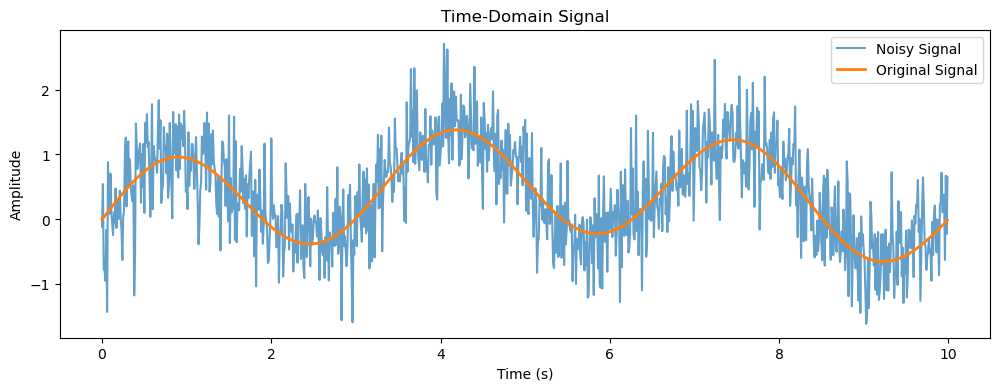

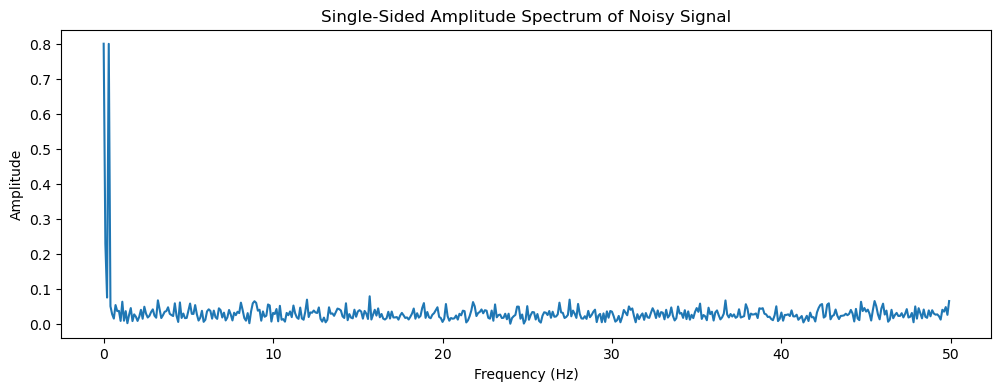

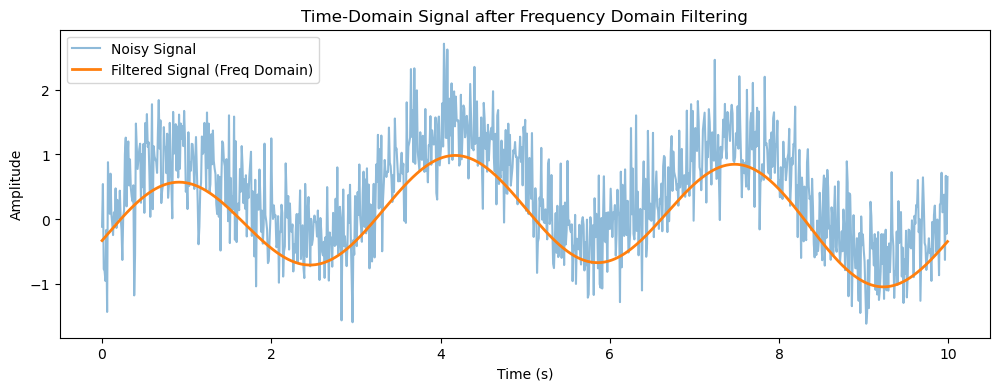

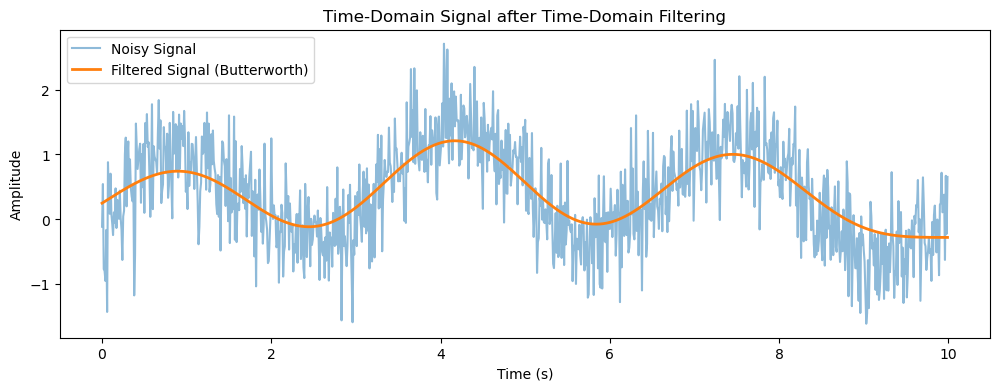

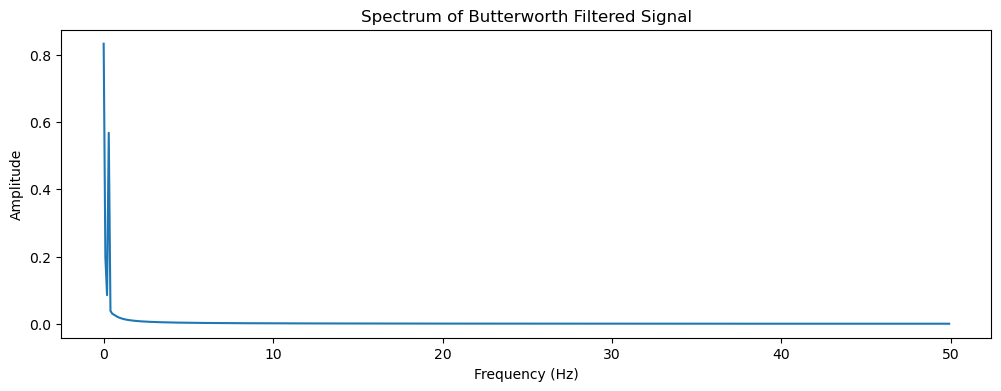

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt

# --- Parameters ---
fs = 100.0                     # Sampling frequency (Hz)
t_end = 10                     # Duration of the signal in seconds
ts = np.linspace(0, t_end, int(t_end*fs), endpoint=False)

# --- Define the Signal ---
# Signal for joint 0: 0.6*sin(2*pi/10*0.5*ts) + 0.8*sin(2*pi/10*3*ts)
# Simplified: 0.6*sin((pi/10)*ts) and 0.8*sin((3*pi/5)*ts)
signal = 0.6 * np.sin((np.pi/10) * ts) + 0.8 * np.sin((3*np.pi/5) * ts)

# --- Add Noise ---
noise = 0.5 * np.random.randn(len(ts))  # Random Gaussian noise
noisy_signal = signal + noise

# --- Plot Time-Domain Signal ---
plt.figure(figsize=(12, 4))
plt.plot(ts, noisy_signal, label="Noisy Signal", alpha=0.7)
plt.plot(ts, signal, label="Original Signal", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time-Domain Signal")
plt.legend()
plt.show()

# --- Frequency-Domain Analysis ---
N = len(ts)
yf = fft(noisy_signal)
xf = fftfreq(N, 1/fs)

# Use only the positive frequencies
mask = xf >= 0
plt.figure(figsize=(12, 4))
plt.plot(xf[mask], np.abs(yf[mask]) * 2 / N)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Single-Sided Amplitude Spectrum of Noisy Signal")
plt.show()

# --- Approach 1: Frequency-Domain Filtering ---
# Create a filter mask that keeps frequencies around 0.05 Hz and 0.3 Hz.
# For example, let’s keep frequencies between 0.03 Hz and 0.35 Hz.
filter_mask = (np.abs(xf) >= 0.03) & (np.abs(xf) <= 0.35)

# Apply the mask (ensure symmetry for negative frequencies)
yf_filtered = yf * filter_mask

# Reconstruct the filtered signal using the inverse FFT
filtered_signal_freq = np.real(ifft(yf_filtered))

plt.figure(figsize=(12, 4))
plt.plot(ts, noisy_signal, label="Noisy Signal", alpha=0.5)
plt.plot(ts, filtered_signal_freq, label="Filtered Signal (Freq Domain)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time-Domain Signal after Frequency Domain Filtering")
plt.legend()
plt.show()

# --- Approach 2: Time-Domain Filtering with a Butterworth Filter ---
# Here we design a low-pass filter with a cutoff slightly above 0.3 Hz.
cutoff = 0.35         # Cutoff frequency in Hz
order = 4             # Filter order
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist

# Design the Butterworth filter
b, a = butter(order, normal_cutoff, btype="low", analog=False)

# Apply zero-phase filtering to avoid phase shift
filtered_signal_time = filtfilt(b, a, noisy_signal)

plt.figure(figsize=(12, 4))
plt.plot(ts, noisy_signal, label="Noisy Signal", alpha=0.5)
plt.plot(ts, filtered_signal_time, label="Filtered Signal (Butterworth)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time-Domain Signal after Time-Domain Filtering")
plt.legend()
plt.show()

# --- Frequency Spectrum of the Filtered Signal (Time-Domain) ---
yf_time_filtered = fft(filtered_signal_time)
plt.figure(figsize=(12, 4))
plt.plot(xf[mask], np.abs(yf_time_filtered[mask]) * 2 / N)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Spectrum of Butterworth Filtered Signal")
plt.show()
